# Notebook2: Predicting CO2 emissions using Neural Networks

Readme: In this notebook, NN models are constructed for CO2 Emission prediction, and the best model is selected and K-means validation is applied.

- **Notebook content**:
    - Design the architecture of NN and explore different model configuration

    - Tune hyperparameters and select the best model

- **Notebook Output**:

    - Best model file

    - The validation and test results of the best model

In [30]:
# %pip install "numpy<2" torch torchvision scikit-learn
# %pip install wandb

In [31]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1 Define Functions

In [32]:
# Define functions
import seaborn as sns
import torch

# 1 plot related functions----------------
# plot predict and true values on validation dataset
def plot_pred_true(y_test, y_pred, ax):

    data = pd.DataFrame({'y_obs': y_test, 'y_pred': y_pred})

    # plt.figure(figsize=(5, 5))
    sns.scatterplot(data=data, x='y_obs', y='y_pred', s=10, ax=ax)
    ax.plot(y_test, y_test, color='red', label='y=x')          # plot the line y=x
    ax.set_title('Observed vs Predicted values in Test Dataset')   # title
    ax.set_xlabel('Observed values')       # label for the x-axis
    ax.set_ylabel('Predicted values')      # label for the y-axis
    ax.legend()
    ax.grid(True)

# plot the loss value on training and validation dataset
def plot_train_val_loss(train_loss, val_loss, ax):
    
    # ax.figure(figsize=(5, 5))

    ax.plot(train_loss, label='train loss')
    ax.plot(val_loss, label='val loss')
    ax.set_title('Train vs Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

# 2 Other functions---------------------
# get the prediction and true values
def model_prediction(model, val_loader, device):

    model.eval()
    pred = []
    target = []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)      # predicted value

            pred.extend(y_pred.cpu().numpy())
            target.extend(y.cpu().numpy())

    # Merge all the predictions and targets
    predictions = np.concatenate(pred, axis=0)
    labels = np.concatenate(target, axis=0)
    return predictions, labels

## 2 Data Preparation

In [33]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Load and Divide Traning and Testing Data

Load the test and train dataset

In [34]:
# Import data
trainset_df = pd.read_csv('Dataset1_train.csv')
testset_df = pd.read_csv('Dataset1_test.csv')


In [35]:
trainset_df

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,...,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z,Make,CO2 Emissions(g/km)
0,4.0,6,1,5.000000,14.7,10.3,12.7,22,0,0,...,0,0,0,0,0,0,1,0,NISSAN,299
1,2.4,4,1,6.000000,9.8,6.7,8.4,34,0,0,...,0,0,0,0,0,0,1,0,HYUNDAI,193
2,2.0,4,1,8.000000,11.3,7.1,9.4,30,0,0,...,0,0,0,0,0,0,0,1,BMW,221
3,2.5,4,1,6.000000,10.1,7.7,9.0,31,0,0,...,1,0,0,0,0,0,1,0,TOYOTA,212
4,5.0,8,1,8.000000,15.8,10.3,13.3,21,0,0,...,0,0,0,0,0,0,0,1,JAGUAR,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5902,2.0,4,1,6.000000,9.3,7.3,8.4,34,0,0,...,0,0,0,0,0,0,0,1,MINI,197
5903,5.6,8,1,7.000000,17.5,12.8,15.4,18,0,1,...,0,1,0,0,0,0,1,0,NISSAN,362
5904,3.5,6,1,6.000000,8.1,8.5,8.3,34,0,0,...,0,1,0,0,0,0,1,0,TOYOTA,193
5905,2.5,4,1,6.854093,9.5,7.4,8.6,33,0,0,...,1,0,0,0,0,0,1,0,NISSAN,198


In [36]:
X_train = trainset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_train = trainset_df['CO2 Emissions(g/km)']

X_test = testset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_test = testset_df['CO2 Emissions(g/km)']

In [37]:
X_train

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,...,Vehicle Class_STATION WAGON - SMALL,Vehicle Class_SUBCOMPACT,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z
0,4.0,6,1,5.000000,14.7,10.3,12.7,22,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2.4,4,1,6.000000,9.8,6.7,8.4,34,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2.0,4,1,8.000000,11.3,7.1,9.4,30,0,0,...,0,1,0,0,0,0,0,0,0,1
3,2.5,4,1,6.000000,10.1,7.7,9.0,31,0,0,...,0,0,1,0,0,0,0,0,1,0
4,5.0,8,1,8.000000,15.8,10.3,13.3,21,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5902,2.0,4,1,6.000000,9.3,7.3,8.4,34,0,0,...,0,1,0,0,0,0,0,0,0,1
5903,5.6,8,1,7.000000,17.5,12.8,15.4,18,0,1,...,0,0,0,1,0,0,0,0,1,0
5904,3.5,6,1,6.000000,8.1,8.5,8.3,34,0,0,...,0,0,0,1,0,0,0,0,1,0
5905,2.5,4,1,6.854093,9.5,7.4,8.6,33,0,0,...,0,0,1,0,0,0,0,0,1,0


### Setup pipline for Standardisation

In [38]:
binary_columns = X_train.columns[X_train.nunique() == 2].tolist()  
numerical_columns = [col for col in X_train.columns if col not in binary_columns]

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # StandardScale
    ], 
    remainder='passthrough'  # keep dummy variable
)

# Setup pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [39]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

Inspect the processed data

In [40]:
feature_names = list(X_train) 
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Processed Train Dataset：")
print(X_train_df.head())

print("Processed Test Dataset：")
print(X_test_df.head())


Processed Train Dataset：
   Engine Size(L)  Cylinders  Gearbox_Type  Gearbox_Number  \
0        0.612690   0.200638     -1.602571        0.606404   
1       -0.567895  -0.889172     -0.750938       -0.792804   
2       -0.863042  -0.889172      0.952329       -0.364475   
3       -0.494109  -0.889172     -0.750938       -0.707138   
4        1.350555   1.290448      0.952329        0.920512   

   Fuel Consumption City (L/100 km)  Fuel Consumption Hwy (L/100 km)  \
0                          0.563352                         0.591736   
1                         -1.064801                        -0.897681   
2                         -0.883895                        -0.551305   
3                         -0.612536                        -0.689855   
4                          0.563352                         0.799561   

   Fuel Consumption Comb (L/100 km)  Fuel Consumption Comb (mpg)  \
0                         -0.753140                          1.0   
1                          0.9101

In [41]:
# Prepare the Dataloader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to Tensor
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Load the training data and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_val_tensor,y_test_tensor)

# Set hyperparameters
batch_size = 64  # batch size

# Create data loader
train_Loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_Loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



## 3 Best Models

#### Pre: k-fold Import K-fold Cross-validation Method

In [42]:
from sklearn.model_selection import KFold

k_fold = KFold(n_splits=20, shuffle=True, random_state=42) # Set randon seed to make sure the results are reproducible

Import metrics

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

### 3.1 Neural Network Model

#### 3.1.1 Use W&B Grid Search to Find Best NN Parameter Set

In [44]:
import wandb

wandb.login(key="47ea61c7ee69e2e0e1cc46ed5c31bd6168f9f9db")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\87383\_netrc


True

Neural Network Structure

In [45]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultiLayerPerceptron, self).__init__()

        # Initialise an empty list to hold layers
        layers = []

        # First layer: input to hidden
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        # Output layer: hidden to output
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [46]:
from torch.utils.data import random_split

# Calculate the sizes for train and validation splits
num_total = len(train_dataset)
num_train = int(0.9 * num_total)
num_val = num_total - num_train

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [num_train, num_val])

# Create DataLoaders for each subset
train_Loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_Loader = DataLoader(val_subset, batch_size=64, shuffle=False)

In [47]:
# Hyperparameter grid
hidden_units_options = [32, 64, 128]    # Numbers of neurons in each hidden layer
hidden_layers_options = [2, 3, 4]       # Numbers of hidden layers
learning_rates = [0.1, 0.01, 0.001]     # Learning rates

max_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
patience = 5      # Early stopping patience

input_size =  X_train_processed.shape[1]   # Input size 
output_size = 1             # Output size

learning_rate = 0.02        # Learning rate
n_epochs = 100 # Numebr of epochs

# Define the loss function and the optimizer
criterion = nn.MSELoss()    # Mean Squared Error for Linear Regression


In [48]:
# Define helper functions
# Train epoch function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    # for features, target in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
    for features, target in train_loader:
        features, target = features.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(features) # Forward pass
        loss = criterion(outputs, target)

        loss.backward()  # Backward pass
        optimizer.step() # Update the weights

        running_loss += loss.item() * features.size(0)

    return running_loss / len(train_loader.dataset)

# Validation epoch function
def val_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for features, target in val_loader:
            # print(featuresfeatures.size(0))
            features, target = features.to(device), target.to(device)
            # features = features.view(features.size(0), -1)

            outputs = model(features)
            loss = criterion(outputs, target)
            val_loss += loss.item() * features.size(0)

    return val_loss / len(val_loader.dataset)



In [49]:
from itertools import product
import torch.optim as optim

for hidden_units, hidden_layers, lr in product(hidden_units_options, hidden_layers_options, learning_rates):

    # Configurations
    config = {
        "hidden_units": hidden_units,
        "hidden_layers": hidden_layers,
        "learning_rate": lr,
        "max_epochs": max_epochs,
        "patience": patience
    }

    # Start a new W&B run for each configuration
    wandb.init(project='DE_Groupwork_G4_stage1', config=config, reinit=True)

    model = MultiLayerPerceptron(input_size=input_size, 
                             hidden_size=config["hidden_units"], 
                             num_layers=config["hidden_layers"], 
                             output_size=1).to(device)


    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_test_loss = float('inf')
    epochs_without_improvement = 0
        
    for epoch in range(1, max_epochs + 1):
        train_loss = train_epoch(model, train_Loader, criterion, optimizer, device)
       
        test_loss = val_epoch(model, test_Loader, criterion, device)

        # Log metrics to W&B
        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": test_loss})
        
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {test_loss:.4f}")
        
        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    wandb.finish()

print("Training complete for all configurations.")


Epoch 001 | Train Loss: 5717.5943 | Val Loss: 666.1507
Epoch 002 | Train Loss: 363.3433 | Val Loss: 232.0713
Epoch 003 | Train Loss: 173.5053 | Val Loss: 149.3998
Epoch 004 | Train Loss: 92.4356 | Val Loss: 69.7635
Epoch 005 | Train Loss: 53.7239 | Val Loss: 49.0899
Epoch 006 | Train Loss: 36.8657 | Val Loss: 40.1078
Epoch 007 | Train Loss: 27.9894 | Val Loss: 42.0073
Epoch 008 | Train Loss: 22.8708 | Val Loss: 33.0574
Epoch 009 | Train Loss: 26.5218 | Val Loss: 35.4833
Epoch 010 | Train Loss: 28.7553 | Val Loss: 23.3411
Epoch 011 | Train Loss: 19.5701 | Val Loss: 30.4865
Epoch 012 | Train Loss: 27.2840 | Val Loss: 32.6825
Epoch 013 | Train Loss: 40.7054 | Val Loss: 28.1647
Epoch 014 | Train Loss: 23.0123 | Val Loss: 17.3588
Epoch 015 | Train Loss: 32.1450 | Val Loss: 37.3869
Epoch 016 | Train Loss: 32.1743 | Val Loss: 43.4468
Epoch 017 | Train Loss: 20.3542 | Val Loss: 20.9850
Epoch 018 | Train Loss: 57.2386 | Val Loss: 42.4950
Epoch 019 | Train Loss: 28.2720 | Val Loss: 21.8686
Early

epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19
train_loss,28.27202
val_loss,21.86862


Epoch 001 | Train Loss: 25316.9573 | Val Loss: 1291.3895
Epoch 002 | Train Loss: 850.8184 | Val Loss: 664.7035
Epoch 003 | Train Loss: 519.2616 | Val Loss: 462.3500
Epoch 004 | Train Loss: 369.8000 | Val Loss: 346.1611
Epoch 005 | Train Loss: 281.4095 | Val Loss: 276.6102
Epoch 006 | Train Loss: 223.6443 | Val Loss: 229.4348
Epoch 007 | Train Loss: 180.9367 | Val Loss: 183.1165
Epoch 008 | Train Loss: 141.9296 | Val Loss: 144.6184
Epoch 009 | Train Loss: 114.0673 | Val Loss: 118.9416
Epoch 010 | Train Loss: 90.2023 | Val Loss: 89.9267
Epoch 011 | Train Loss: 70.9391 | Val Loss: 75.8518
Epoch 012 | Train Loss: 57.1542 | Val Loss: 58.4642
Epoch 013 | Train Loss: 46.7473 | Val Loss: 49.7587
Epoch 014 | Train Loss: 39.1981 | Val Loss: 59.0036
Epoch 015 | Train Loss: 39.1452 | Val Loss: 33.3568
Epoch 016 | Train Loss: 28.6720 | Val Loss: 28.9635
Epoch 017 | Train Loss: 25.7903 | Val Loss: 29.3893
Epoch 018 | Train Loss: 23.8429 | Val Loss: 24.2738
Epoch 019 | Train Loss: 21.8064 | Val Loss:

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
train_loss,10.99931
val_loss,21.52483


Epoch 001 | Train Loss: 65647.0014 | Val Loss: 62616.8588
Epoch 002 | Train Loss: 56103.3447 | Val Loss: 43250.7862
Epoch 003 | Train Loss: 27538.5564 | Val Loss: 12236.6826
Epoch 004 | Train Loss: 6786.2004 | Val Loss: 4045.8423
Epoch 005 | Train Loss: 3250.6157 | Val Loss: 2581.3177
Epoch 006 | Train Loss: 2187.2391 | Val Loss: 1879.6112
Epoch 007 | Train Loss: 1623.0232 | Val Loss: 1485.7050
Epoch 008 | Train Loss: 1297.2686 | Val Loss: 1254.9352
Epoch 009 | Train Loss: 1101.2140 | Val Loss: 1104.9292
Epoch 010 | Train Loss: 980.4970 | Val Loss: 1008.1260
Epoch 011 | Train Loss: 893.9860 | Val Loss: 930.9896
Epoch 012 | Train Loss: 828.7006 | Val Loss: 868.9976
Epoch 013 | Train Loss: 774.9180 | Val Loss: 815.1266
Epoch 014 | Train Loss: 728.0204 | Val Loss: 766.0793
Epoch 015 | Train Loss: 685.9386 | Val Loss: 721.5221
Epoch 016 | Train Loss: 646.4660 | Val Loss: 683.8562
Epoch 017 | Train Loss: 610.7730 | Val Loss: 646.4223
Epoch 018 | Train Loss: 577.5869 | Val Loss: 610.8192
Epo

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,152
train_loss,8.50956
val_loss,9.46526


Epoch 001 | Train Loss: 9899.3538 | Val Loss: 628.3049
Epoch 002 | Train Loss: 413.2805 | Val Loss: 335.9003
Epoch 003 | Train Loss: 243.8844 | Val Loss: 199.0719
Epoch 004 | Train Loss: 152.9539 | Val Loss: 122.6484
Epoch 005 | Train Loss: 97.8045 | Val Loss: 290.4352
Epoch 006 | Train Loss: 97.3576 | Val Loss: 49.1234
Epoch 007 | Train Loss: 48.5313 | Val Loss: 73.5997
Epoch 008 | Train Loss: 48.7643 | Val Loss: 37.2394
Epoch 009 | Train Loss: 41.2107 | Val Loss: 154.9949
Epoch 010 | Train Loss: 54.5367 | Val Loss: 48.2737
Epoch 011 | Train Loss: 35.7325 | Val Loss: 110.3574
Epoch 012 | Train Loss: 38.0098 | Val Loss: 28.4317
Epoch 013 | Train Loss: 30.0403 | Val Loss: 40.7690
Epoch 014 | Train Loss: 27.3259 | Val Loss: 44.3389
Epoch 015 | Train Loss: 29.8282 | Val Loss: 33.3400
Epoch 016 | Train Loss: 28.4751 | Val Loss: 44.8349
Epoch 017 | Train Loss: 49.3916 | Val Loss: 143.3532
Early stopping triggered at epoch 17


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▄▁▂▁▂▁▂▁▁▁▁▁▂
epoch,17
train_loss,49.39161
val_loss,143.35324


Epoch 001 | Train Loss: 17803.3696 | Val Loss: 761.9773
Epoch 002 | Train Loss: 499.9060 | Val Loss: 385.6631
Epoch 003 | Train Loss: 295.2925 | Val Loss: 272.2727
Epoch 004 | Train Loss: 213.1559 | Val Loss: 203.7825
Epoch 005 | Train Loss: 157.3619 | Val Loss: 149.3154
Epoch 006 | Train Loss: 112.2195 | Val Loss: 103.6933
Epoch 007 | Train Loss: 74.6813 | Val Loss: 65.3903
Epoch 008 | Train Loss: 51.0523 | Val Loss: 46.1457
Epoch 009 | Train Loss: 35.8754 | Val Loss: 29.5069
Epoch 010 | Train Loss: 27.6323 | Val Loss: 24.1347
Epoch 011 | Train Loss: 24.5384 | Val Loss: 31.3685
Epoch 012 | Train Loss: 21.5918 | Val Loss: 22.1023
Epoch 013 | Train Loss: 21.3816 | Val Loss: 16.7954
Epoch 014 | Train Loss: 18.0918 | Val Loss: 20.3643
Epoch 015 | Train Loss: 17.5532 | Val Loss: 15.8090
Epoch 016 | Train Loss: 16.8668 | Val Loss: 13.9166
Epoch 017 | Train Loss: 15.8262 | Val Loss: 14.8373
Epoch 018 | Train Loss: 14.5712 | Val Loss: 14.9932
Epoch 019 | Train Loss: 13.8234 | Val Loss: 21.870

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,21
train_loss,12.76536
val_loss,13.97186


Epoch 001 | Train Loss: 64912.9399 | Val Loss: 56991.5523
Epoch 002 | Train Loss: 25437.6424 | Val Loss: 4237.1677
Epoch 003 | Train Loss: 2630.1420 | Val Loss: 1617.1250
Epoch 004 | Train Loss: 1201.9653 | Val Loss: 997.8393
Epoch 005 | Train Loss: 812.1183 | Val Loss: 762.7403
Epoch 006 | Train Loss: 643.9585 | Val Loss: 624.8088
Epoch 007 | Train Loss: 520.8142 | Val Loss: 510.6599
Epoch 008 | Train Loss: 424.4776 | Val Loss: 424.2105
Epoch 009 | Train Loss: 352.3101 | Val Loss: 361.6612
Epoch 010 | Train Loss: 302.2848 | Val Loss: 314.5185
Epoch 011 | Train Loss: 265.5283 | Val Loss: 283.1181
Epoch 012 | Train Loss: 238.2056 | Val Loss: 255.6383
Epoch 013 | Train Loss: 214.6689 | Val Loss: 233.1230
Epoch 014 | Train Loss: 197.8841 | Val Loss: 215.2018
Epoch 015 | Train Loss: 179.8849 | Val Loss: 200.3475
Epoch 016 | Train Loss: 165.5631 | Val Loss: 183.1826
Epoch 017 | Train Loss: 151.9249 | Val Loss: 166.5428
Epoch 018 | Train Loss: 138.4459 | Val Loss: 152.5039
Epoch 019 | Train 

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,63
train_loss,11.49873
val_loss,13.36866


Epoch 001 | Train Loss: 69195.9006 | Val Loss: 62037.1402
Epoch 002 | Train Loss: 61084.0368 | Val Loss: 58164.5816
Epoch 003 | Train Loss: 57267.8944 | Val Loss: 54473.1564
Epoch 004 | Train Loss: 53636.0276 | Val Loss: 50972.6031
Epoch 005 | Train Loss: 50188.3909 | Val Loss: 47639.8924
Epoch 006 | Train Loss: 46903.9259 | Val Loss: 44480.0766
Epoch 007 | Train Loss: 43797.5705 | Val Loss: 41489.0324
Epoch 008 | Train Loss: 40848.0853 | Val Loss: 38654.8899
Epoch 009 | Train Loss: 38063.4402 | Val Loss: 35984.7453
Epoch 010 | Train Loss: 35432.7261 | Val Loss: 33460.2442
Epoch 011 | Train Loss: 32957.0006 | Val Loss: 31087.1442
Epoch 012 | Train Loss: 30616.3724 | Val Loss: 28845.3469
Epoch 013 | Train Loss: 28417.8482 | Val Loss: 26745.3660
Epoch 014 | Train Loss: 26350.0130 | Val Loss: 24774.1208
Epoch 015 | Train Loss: 24409.4898 | Val Loss: 22917.2947
Epoch 016 | Train Loss: 22587.3904 | Val Loss: 21186.4329
Epoch 017 | Train Loss: 20886.2406 | Val Loss: 19567.0545
Epoch 018 | Tr

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
train_loss,█▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▆▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,62
train_loss,3422.03893
val_loss,3478.49513


Epoch 001 | Train Loss: 15558.0906 | Val Loss: 664.0970
Epoch 002 | Train Loss: 421.0222 | Val Loss: 343.2390
Epoch 003 | Train Loss: 244.9498 | Val Loss: 220.8558
Epoch 004 | Train Loss: 160.6232 | Val Loss: 142.9436
Epoch 005 | Train Loss: 107.2486 | Val Loss: 99.8338
Epoch 006 | Train Loss: 71.0943 | Val Loss: 53.6563
Epoch 007 | Train Loss: 41.4081 | Val Loss: 43.5716
Epoch 008 | Train Loss: 32.1820 | Val Loss: 34.4623
Epoch 009 | Train Loss: 28.8888 | Val Loss: 23.7862
Epoch 010 | Train Loss: 23.0077 | Val Loss: 35.8355
Epoch 011 | Train Loss: 25.8595 | Val Loss: 17.5984
Epoch 012 | Train Loss: 21.4834 | Val Loss: 19.2807
Epoch 013 | Train Loss: 19.0335 | Val Loss: 22.9111
Epoch 014 | Train Loss: 15.7014 | Val Loss: 23.9344
Epoch 015 | Train Loss: 15.3719 | Val Loss: 16.2468
Epoch 016 | Train Loss: 14.8465 | Val Loss: 17.1540
Epoch 017 | Train Loss: 14.3468 | Val Loss: 16.3460
Epoch 018 | Train Loss: 14.9268 | Val Loss: 66.6642
Epoch 019 | Train Loss: 18.0886 | Val Loss: 13.0200
E

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch,28
train_loss,15.22017
val_loss,53.05472


Epoch 001 | Train Loss: 65002.9990 | Val Loss: 54949.2965
Epoch 002 | Train Loss: 17007.6990 | Val Loss: 2569.8600
Epoch 003 | Train Loss: 1723.1537 | Val Loss: 1169.6260
Epoch 004 | Train Loss: 929.5668 | Val Loss: 811.9976
Epoch 005 | Train Loss: 685.0251 | Val Loss: 648.8168
Epoch 006 | Train Loss: 561.2855 | Val Loss: 543.1513
Epoch 007 | Train Loss: 474.4724 | Val Loss: 469.7671
Epoch 008 | Train Loss: 406.1066 | Val Loss: 408.8059
Epoch 009 | Train Loss: 353.9983 | Val Loss: 361.1040
Epoch 010 | Train Loss: 312.6304 | Val Loss: 325.4957
Epoch 011 | Train Loss: 277.9530 | Val Loss: 294.6558
Epoch 012 | Train Loss: 250.1419 | Val Loss: 268.7345
Epoch 013 | Train Loss: 227.0401 | Val Loss: 246.4814
Epoch 014 | Train Loss: 207.7954 | Val Loss: 226.9779
Epoch 015 | Train Loss: 192.7140 | Val Loss: 208.7338
Epoch 016 | Train Loss: 176.3265 | Val Loss: 193.6987
Epoch 017 | Train Loss: 163.0415 | Val Loss: 181.0163
Epoch 018 | Train Loss: 150.6663 | Val Loss: 163.6914
Epoch 019 | Train L

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,69
train_loss,12.8163
val_loss,14.96617


Epoch 001 | Train Loss: 4187.6556 | Val Loss: 440.3182
Epoch 002 | Train Loss: 256.9139 | Val Loss: 275.5912
Epoch 003 | Train Loss: 135.3305 | Val Loss: 121.0522
Epoch 004 | Train Loss: 64.8838 | Val Loss: 57.2850
Epoch 005 | Train Loss: 43.9783 | Val Loss: 222.4493
Epoch 006 | Train Loss: 89.9906 | Val Loss: 52.5543
Epoch 007 | Train Loss: 38.2591 | Val Loss: 29.3400
Epoch 008 | Train Loss: 22.4734 | Val Loss: 46.3498
Epoch 009 | Train Loss: 48.5891 | Val Loss: 53.0536
Epoch 010 | Train Loss: 60.9865 | Val Loss: 107.2485
Epoch 011 | Train Loss: 47.3441 | Val Loss: 96.2116
Epoch 012 | Train Loss: 54.1715 | Val Loss: 27.5434
Epoch 013 | Train Loss: 64.1908 | Val Loss: 97.2295
Epoch 014 | Train Loss: 43.8920 | Val Loss: 60.5818
Epoch 015 | Train Loss: 414.3060 | Val Loss: 33.7101
Epoch 016 | Train Loss: 28.3996 | Val Loss: 64.0294
Epoch 017 | Train Loss: 25.0434 | Val Loss: 14.1069
Epoch 018 | Train Loss: 18.5471 | Val Loss: 213.9721
Epoch 019 | Train Loss: 70.8366 | Val Loss: 13.2770
E

epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▄▂▁▂▂▃▂▁▂▂▁▂▁▄▁▁▁▃▂▅
epoch,24
train_loss,48.25307
val_loss,282.15157


Epoch 001 | Train Loss: 17598.1623 | Val Loss: 823.3966
Epoch 002 | Train Loss: 583.8914 | Val Loss: 461.6001
Epoch 003 | Train Loss: 359.5473 | Val Loss: 337.2674
Epoch 004 | Train Loss: 259.4081 | Val Loss: 255.9220
Epoch 005 | Train Loss: 195.3547 | Val Loss: 203.8070
Epoch 006 | Train Loss: 152.7178 | Val Loss: 144.7426
Epoch 007 | Train Loss: 108.6150 | Val Loss: 102.9485
Epoch 008 | Train Loss: 80.0868 | Val Loss: 81.3044
Epoch 009 | Train Loss: 58.0282 | Val Loss: 53.8664
Epoch 010 | Train Loss: 44.2115 | Val Loss: 42.4221
Epoch 011 | Train Loss: 36.3708 | Val Loss: 32.5775
Epoch 012 | Train Loss: 28.7135 | Val Loss: 27.8407
Epoch 013 | Train Loss: 25.4113 | Val Loss: 24.5321
Epoch 014 | Train Loss: 24.2823 | Val Loss: 27.0630
Epoch 015 | Train Loss: 21.3605 | Val Loss: 18.9260
Epoch 016 | Train Loss: 22.1375 | Val Loss: 20.6842
Epoch 017 | Train Loss: 19.0863 | Val Loss: 19.0613
Epoch 018 | Train Loss: 17.3222 | Val Loss: 15.9064
Epoch 019 | Train Loss: 16.8616 | Val Loss: 20.0

epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
train_loss,13.36129
val_loss,17.26414


Epoch 001 | Train Loss: 64129.0856 | Val Loss: 55658.6832
Epoch 002 | Train Loss: 33266.3709 | Val Loss: 8907.4755
Epoch 003 | Train Loss: 4739.4426 | Val Loss: 2936.7116
Epoch 004 | Train Loss: 2226.9835 | Val Loss: 1699.9350
Epoch 005 | Train Loss: 1378.6497 | Val Loss: 1222.0035
Epoch 006 | Train Loss: 1040.8051 | Val Loss: 1003.1344
Epoch 007 | Train Loss: 876.4765 | Val Loss: 879.1721
Epoch 008 | Train Loss: 776.6243 | Val Loss: 790.5191
Epoch 009 | Train Loss: 702.2983 | Val Loss: 724.4271
Epoch 010 | Train Loss: 642.4874 | Val Loss: 661.1915
Epoch 011 | Train Loss: 590.2325 | Val Loss: 608.7389
Epoch 012 | Train Loss: 542.9448 | Val Loss: 565.9718
Epoch 013 | Train Loss: 503.3270 | Val Loss: 524.2650
Epoch 014 | Train Loss: 466.2617 | Val Loss: 489.6802
Epoch 015 | Train Loss: 432.9167 | Val Loss: 457.3368
Epoch 016 | Train Loss: 404.0803 | Val Loss: 426.2305
Epoch 017 | Train Loss: 377.0178 | Val Loss: 400.8085
Epoch 018 | Train Loss: 353.5473 | Val Loss: 378.6406
Epoch 019 | T

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇█████
train_loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,101
train_loss,10.2015
val_loss,11.04463


Epoch 001 | Train Loss: 20831.9501 | Val Loss: 594.3744
Epoch 002 | Train Loss: 383.1675 | Val Loss: 296.0490
Epoch 003 | Train Loss: 218.7905 | Val Loss: 249.1873
Epoch 004 | Train Loss: 172.0590 | Val Loss: 118.5808
Epoch 005 | Train Loss: 97.3325 | Val Loss: 89.1121
Epoch 006 | Train Loss: 89.3063 | Val Loss: 94.2993
Epoch 007 | Train Loss: 67.0969 | Val Loss: 110.2943
Epoch 008 | Train Loss: 64.4974 | Val Loss: 63.5031
Epoch 009 | Train Loss: 45.9476 | Val Loss: 274.7471
Epoch 010 | Train Loss: 84.7849 | Val Loss: 79.4640
Epoch 011 | Train Loss: 42.6812 | Val Loss: 100.4448
Epoch 012 | Train Loss: 35.0330 | Val Loss: 66.0305
Epoch 013 | Train Loss: 47.3753 | Val Loss: 44.2408
Epoch 014 | Train Loss: 33.0544 | Val Loss: 20.9786
Epoch 015 | Train Loss: 35.9519 | Val Loss: 28.6132
Epoch 016 | Train Loss: 25.1082 | Val Loss: 56.7448
Epoch 017 | Train Loss: 28.4636 | Val Loss: 99.7289
Epoch 018 | Train Loss: 51.1479 | Val Loss: 23.9373
Epoch 019 | Train Loss: 34.9107 | Val Loss: 23.8639

epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▂▂▂▂▂▄▂▂▂▁▁▁▁▂▁▁
epoch,19
train_loss,34.91073
val_loss,23.86391


Epoch 001 | Train Loss: 11600.0596 | Val Loss: 633.5897
Epoch 002 | Train Loss: 399.8350 | Val Loss: 317.4954
Epoch 003 | Train Loss: 235.7894 | Val Loss: 227.4374
Epoch 004 | Train Loss: 161.0755 | Val Loss: 150.6790
Epoch 005 | Train Loss: 104.4472 | Val Loss: 98.4318
Epoch 006 | Train Loss: 61.9415 | Val Loss: 61.0464
Epoch 007 | Train Loss: 41.9011 | Val Loss: 32.7850
Epoch 008 | Train Loss: 31.3148 | Val Loss: 29.8961
Epoch 009 | Train Loss: 25.4821 | Val Loss: 27.8618
Epoch 010 | Train Loss: 22.6058 | Val Loss: 29.3318
Epoch 011 | Train Loss: 21.7863 | Val Loss: 22.4006
Epoch 012 | Train Loss: 23.8772 | Val Loss: 19.1042
Epoch 013 | Train Loss: 17.4949 | Val Loss: 16.9492
Epoch 014 | Train Loss: 15.3620 | Val Loss: 23.6102
Epoch 015 | Train Loss: 20.8910 | Val Loss: 21.1847
Epoch 016 | Train Loss: 21.4655 | Val Loss: 18.3398
Epoch 017 | Train Loss: 15.2780 | Val Loss: 73.8261
Epoch 018 | Train Loss: 33.9530 | Val Loss: 27.7695
Early stopping triggered at epoch 18


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▂▁
epoch,18
train_loss,33.953
val_loss,27.76949


Epoch 001 | Train Loss: 61485.6923 | Val Loss: 36564.8841
Epoch 002 | Train Loss: 8780.6011 | Val Loss: 2173.8472
Epoch 003 | Train Loss: 1427.6905 | Val Loss: 1012.4125
Epoch 004 | Train Loss: 802.8422 | Val Loss: 740.4796
Epoch 005 | Train Loss: 620.5356 | Val Loss: 612.2392
Epoch 006 | Train Loss: 517.9040 | Val Loss: 525.5651
Epoch 007 | Train Loss: 446.8132 | Val Loss: 457.2884
Epoch 008 | Train Loss: 391.1197 | Val Loss: 404.4314
Epoch 009 | Train Loss: 346.7102 | Val Loss: 362.0123
Epoch 010 | Train Loss: 309.6108 | Val Loss: 330.5559
Epoch 011 | Train Loss: 280.3354 | Val Loss: 300.0504
Epoch 012 | Train Loss: 254.5201 | Val Loss: 278.0857
Epoch 013 | Train Loss: 230.7168 | Val Loss: 255.3855
Epoch 014 | Train Loss: 213.1495 | Val Loss: 236.3320
Epoch 015 | Train Loss: 195.5800 | Val Loss: 217.2995
Epoch 016 | Train Loss: 180.6910 | Val Loss: 201.7822
Epoch 017 | Train Loss: 165.9349 | Val Loss: 185.9583
Epoch 018 | Train Loss: 152.4848 | Val Loss: 171.4936
Epoch 019 | Train Lo

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,87
train_loss,8.80972
val_loss,21.13951


Epoch 001 | Train Loss: 27623.1732 | Val Loss: 893.2814
Epoch 002 | Train Loss: 324.0498 | Val Loss: 241.9794
Epoch 003 | Train Loss: 162.4272 | Val Loss: 181.9820
Epoch 004 | Train Loss: 134.2179 | Val Loss: 141.8725
Epoch 005 | Train Loss: 90.6267 | Val Loss: 89.7517
Epoch 006 | Train Loss: 64.7741 | Val Loss: 288.1720
Epoch 007 | Train Loss: 90.7974 | Val Loss: 82.7215
Epoch 008 | Train Loss: 49.8785 | Val Loss: 160.3755
Epoch 009 | Train Loss: 50.0328 | Val Loss: 36.1025
Epoch 010 | Train Loss: 36.5408 | Val Loss: 64.4482
Epoch 011 | Train Loss: 55.6078 | Val Loss: 51.6056
Epoch 012 | Train Loss: 39.5468 | Val Loss: 29.4383
Epoch 013 | Train Loss: 41.4456 | Val Loss: 72.3724
Epoch 014 | Train Loss: 51.9165 | Val Loss: 56.5278
Epoch 015 | Train Loss: 34.7409 | Val Loss: 66.3686
Epoch 016 | Train Loss: 29.9102 | Val Loss: 57.8277
Epoch 017 | Train Loss: 45.0887 | Val Loss: 22.7954
Epoch 018 | Train Loss: 41.3836 | Val Loss: 144.6386
Epoch 019 | Train Loss: 150.3406 | Val Loss: 5570.6

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
epoch,22
train_loss,29.25908
val_loss,29.05427


Epoch 001 | Train Loss: 11885.6455 | Val Loss: 548.4128
Epoch 002 | Train Loss: 388.3209 | Val Loss: 318.2497
Epoch 003 | Train Loss: 230.6717 | Val Loss: 203.9192
Epoch 004 | Train Loss: 149.8901 | Val Loss: 146.0708
Epoch 005 | Train Loss: 97.5598 | Val Loss: 81.3620
Epoch 006 | Train Loss: 57.2056 | Val Loss: 46.9883
Epoch 007 | Train Loss: 35.9697 | Val Loss: 32.7199
Epoch 008 | Train Loss: 26.1571 | Val Loss: 24.8887
Epoch 009 | Train Loss: 22.6280 | Val Loss: 24.2784
Epoch 010 | Train Loss: 21.3490 | Val Loss: 24.5179
Epoch 011 | Train Loss: 19.8620 | Val Loss: 22.1886
Epoch 012 | Train Loss: 18.1390 | Val Loss: 27.6972
Epoch 013 | Train Loss: 16.1457 | Val Loss: 23.3264
Epoch 014 | Train Loss: 16.2518 | Val Loss: 37.2763
Epoch 015 | Train Loss: 19.7769 | Val Loss: 13.2052
Epoch 016 | Train Loss: 13.6343 | Val Loss: 15.4915
Epoch 017 | Train Loss: 14.7213 | Val Loss: 25.6685
Epoch 018 | Train Loss: 14.2354 | Val Loss: 119.6186
Epoch 019 | Train Loss: 32.2189 | Val Loss: 21.3148
E

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
epoch,20
train_loss,16.55696
val_loss,37.80539


Epoch 001 | Train Loss: 46464.1987 | Val Loss: 5050.3280
Epoch 002 | Train Loss: 2330.7538 | Val Loss: 1066.3031
Epoch 003 | Train Loss: 763.3784 | Val Loss: 616.8492
Epoch 004 | Train Loss: 503.0575 | Val Loss: 479.0662
Epoch 005 | Train Loss: 392.1001 | Val Loss: 387.2916
Epoch 006 | Train Loss: 320.4565 | Val Loss: 327.8699
Epoch 007 | Train Loss: 270.3148 | Val Loss: 287.6192
Epoch 008 | Train Loss: 235.9275 | Val Loss: 251.5934
Epoch 009 | Train Loss: 206.9127 | Val Loss: 223.2245
Epoch 010 | Train Loss: 180.3989 | Val Loss: 198.8242
Epoch 011 | Train Loss: 161.8321 | Val Loss: 177.8518
Epoch 012 | Train Loss: 143.5454 | Val Loss: 159.7261
Epoch 013 | Train Loss: 125.8861 | Val Loss: 137.0074
Epoch 014 | Train Loss: 107.1144 | Val Loss: 117.2024
Epoch 015 | Train Loss: 91.0085 | Val Loss: 100.4057
Epoch 016 | Train Loss: 79.4177 | Val Loss: 86.9291
Epoch 017 | Train Loss: 63.6849 | Val Loss: 67.0086
Epoch 018 | Train Loss: 53.2480 | Val Loss: 62.9866
Epoch 019 | Train Loss: 45.346

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,11.39008
val_loss,11.17175


Epoch 001 | Train Loss: 10231.0991 | Val Loss: 499.2174
Epoch 002 | Train Loss: 328.1337 | Val Loss: 312.4330
Epoch 003 | Train Loss: 190.8882 | Val Loss: 151.5523
Epoch 004 | Train Loss: 102.1859 | Val Loss: 83.4423
Epoch 005 | Train Loss: 63.1994 | Val Loss: 75.2912
Epoch 006 | Train Loss: 57.7000 | Val Loss: 62.3364
Epoch 007 | Train Loss: 34.4671 | Val Loss: 81.8713
Epoch 008 | Train Loss: 50.2871 | Val Loss: 45.3024
Epoch 009 | Train Loss: 36.1710 | Val Loss: 38.4446
Epoch 010 | Train Loss: 24.7845 | Val Loss: 43.1100
Epoch 011 | Train Loss: 26.4989 | Val Loss: 27.2867
Epoch 012 | Train Loss: 35.2149 | Val Loss: 49.0132
Epoch 013 | Train Loss: 38.6346 | Val Loss: 87.5252
Epoch 014 | Train Loss: 47.6612 | Val Loss: 42.9471
Epoch 015 | Train Loss: 27.0052 | Val Loss: 601.3166
Epoch 016 | Train Loss: 146.8041 | Val Loss: 123.4397
Early stopping triggered at epoch 16


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▄▃▂▂▁▂▁▁▁▁▁▂▁█▂
epoch,16
train_loss,146.80406
val_loss,123.43968


Epoch 001 | Train Loss: 12563.6605 | Val Loss: 686.2958
Epoch 002 | Train Loss: 467.4876 | Val Loss: 379.5508
Epoch 003 | Train Loss: 286.0609 | Val Loss: 281.7680
Epoch 004 | Train Loss: 205.8853 | Val Loss: 217.0164
Epoch 005 | Train Loss: 151.7411 | Val Loss: 146.5584
Epoch 006 | Train Loss: 107.0333 | Val Loss: 103.3613
Epoch 007 | Train Loss: 73.0249 | Val Loss: 75.0134
Epoch 008 | Train Loss: 51.7163 | Val Loss: 49.9416
Epoch 009 | Train Loss: 36.7517 | Val Loss: 43.3750
Epoch 010 | Train Loss: 27.6804 | Val Loss: 36.7540
Epoch 011 | Train Loss: 24.7932 | Val Loss: 27.4259
Epoch 012 | Train Loss: 20.6576 | Val Loss: 17.8797
Epoch 013 | Train Loss: 19.1929 | Val Loss: 17.0894
Epoch 014 | Train Loss: 17.8675 | Val Loss: 22.4751
Epoch 015 | Train Loss: 21.2883 | Val Loss: 14.8985
Epoch 016 | Train Loss: 16.3001 | Val Loss: 19.7020
Epoch 017 | Train Loss: 16.9242 | Val Loss: 15.6440
Epoch 018 | Train Loss: 14.6145 | Val Loss: 17.0224
Epoch 019 | Train Loss: 14.3372 | Val Loss: 24.138

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,14.43727
val_loss,16.23474


Epoch 001 | Train Loss: 57719.5908 | Val Loss: 31819.2674
Epoch 002 | Train Loss: 9468.9492 | Val Loss: 2656.9485
Epoch 003 | Train Loss: 1830.7863 | Val Loss: 1312.0033
Epoch 004 | Train Loss: 1050.2241 | Val Loss: 942.8868
Epoch 005 | Train Loss: 806.8395 | Val Loss: 789.0333
Epoch 006 | Train Loss: 684.0044 | Val Loss: 679.7092
Epoch 007 | Train Loss: 593.8284 | Val Loss: 598.3477
Epoch 008 | Train Loss: 522.9638 | Val Loss: 538.4953
Epoch 009 | Train Loss: 464.7954 | Val Loss: 478.5147
Epoch 010 | Train Loss: 417.0462 | Val Loss: 435.0740
Epoch 011 | Train Loss: 375.7448 | Val Loss: 396.7316
Epoch 012 | Train Loss: 341.3802 | Val Loss: 366.7629
Epoch 013 | Train Loss: 313.1228 | Val Loss: 338.9520
Epoch 014 | Train Loss: 287.1099 | Val Loss: 315.8081
Epoch 015 | Train Loss: 267.2188 | Val Loss: 295.9254
Epoch 016 | Train Loss: 247.4772 | Val Loss: 275.4009
Epoch 017 | Train Loss: 231.0745 | Val Loss: 258.4303
Epoch 018 | Train Loss: 215.9157 | Val Loss: 243.1834
Epoch 019 | Train L

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,91
train_loss,8.97748
val_loss,12.04282


Epoch 001 | Train Loss: 32846.7535 | Val Loss: 638.2401
Epoch 002 | Train Loss: 302.7240 | Val Loss: 190.4928
Epoch 003 | Train Loss: 141.4324 | Val Loss: 123.2716
Epoch 004 | Train Loss: 102.9270 | Val Loss: 94.4337
Epoch 005 | Train Loss: 86.1156 | Val Loss: 84.5812
Epoch 006 | Train Loss: 67.4241 | Val Loss: 70.6719
Epoch 007 | Train Loss: 58.3880 | Val Loss: 94.6009
Epoch 008 | Train Loss: 59.8513 | Val Loss: 66.1737
Epoch 009 | Train Loss: 48.1419 | Val Loss: 47.5974
Epoch 010 | Train Loss: 53.8375 | Val Loss: 635.8189
Epoch 011 | Train Loss: 320.7371 | Val Loss: 68.5617
Epoch 012 | Train Loss: 45.9428 | Val Loss: 48.7505
Epoch 013 | Train Loss: 41.0859 | Val Loss: 39.7456
Epoch 014 | Train Loss: 37.0141 | Val Loss: 87.3835
Epoch 015 | Train Loss: 49.4858 | Val Loss: 36.7934
Epoch 016 | Train Loss: 30.0337 | Val Loss: 28.1973
Epoch 017 | Train Loss: 29.1790 | Val Loss: 30.0497
Epoch 018 | Train Loss: 28.4970 | Val Loss: 221.9906
Epoch 019 | Train Loss: 98.7216 | Val Loss: 32.7896


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▂▁▁█▁▁▁▂▁▁▁▃▁▁▁
epoch,21
train_loss,30.39844
val_loss,39.73742


Epoch 001 | Train Loss: 8860.6798 | Val Loss: 484.6589
Epoch 002 | Train Loss: 322.5511 | Val Loss: 255.0711
Epoch 003 | Train Loss: 175.3148 | Val Loss: 185.9105
Epoch 004 | Train Loss: 104.0856 | Val Loss: 84.3929
Epoch 005 | Train Loss: 58.1954 | Val Loss: 48.0875
Epoch 006 | Train Loss: 40.4636 | Val Loss: 30.2694
Epoch 007 | Train Loss: 39.5800 | Val Loss: 61.3914
Epoch 008 | Train Loss: 35.8798 | Val Loss: 26.5390
Epoch 009 | Train Loss: 25.7912 | Val Loss: 25.2928
Epoch 010 | Train Loss: 28.1006 | Val Loss: 22.0323
Epoch 011 | Train Loss: 21.3522 | Val Loss: 34.2554
Epoch 012 | Train Loss: 20.9658 | Val Loss: 17.5963
Epoch 013 | Train Loss: 20.0518 | Val Loss: 27.7720
Epoch 014 | Train Loss: 29.8025 | Val Loss: 16.3870
Epoch 015 | Train Loss: 15.6294 | Val Loss: 15.7477
Epoch 016 | Train Loss: 16.7209 | Val Loss: 18.5505
Epoch 017 | Train Loss: 14.2245 | Val Loss: 16.6924
Epoch 018 | Train Loss: 26.0129 | Val Loss: 211.0936
Epoch 019 | Train Loss: 44.8953 | Val Loss: 86.7325
Epo

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▂▁▁▂▁▁▁▁▁▁▁▁▁▁▄▂▁
epoch,20
train_loss,21.19032
val_loss,23.27406


Epoch 001 | Train Loss: 38011.1263 | Val Loss: 3661.0388
Epoch 002 | Train Loss: 1693.3878 | Val Loss: 875.2203
Epoch 003 | Train Loss: 660.1275 | Val Loss: 574.0461
Epoch 004 | Train Loss: 466.9219 | Val Loss: 443.3040
Epoch 005 | Train Loss: 366.5235 | Val Loss: 368.4375
Epoch 006 | Train Loss: 298.2496 | Val Loss: 310.8816
Epoch 007 | Train Loss: 252.0473 | Val Loss: 269.5367
Epoch 008 | Train Loss: 215.6843 | Val Loss: 228.9304
Epoch 009 | Train Loss: 184.7281 | Val Loss: 200.2512
Epoch 010 | Train Loss: 158.8129 | Val Loss: 173.5963
Epoch 011 | Train Loss: 138.0034 | Val Loss: 150.8910
Epoch 012 | Train Loss: 118.9502 | Val Loss: 128.4912
Epoch 013 | Train Loss: 100.5238 | Val Loss: 109.9235
Epoch 014 | Train Loss: 84.9787 | Val Loss: 98.1705
Epoch 015 | Train Loss: 73.0466 | Val Loss: 73.3038
Epoch 016 | Train Loss: 58.4714 | Val Loss: 60.2274
Epoch 017 | Train Loss: 50.1885 | Val Loss: 51.5393
Epoch 018 | Train Loss: 42.8239 | Val Loss: 43.9590
Epoch 019 | Train Loss: 37.6837 | 

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,58
train_loss,9.95492
val_loss,12.60683


Epoch 001 | Train Loss: 12864.3445 | Val Loss: 440.1628
Epoch 002 | Train Loss: 341.3784 | Val Loss: 256.8739
Epoch 003 | Train Loss: 245.2049 | Val Loss: 615.4346
Epoch 004 | Train Loss: 207.9606 | Val Loss: 96.4129
Epoch 005 | Train Loss: 82.0595 | Val Loss: 113.6404
Epoch 006 | Train Loss: 58.9862 | Val Loss: 37.1227
Epoch 007 | Train Loss: 32.7920 | Val Loss: 50.9038
Epoch 008 | Train Loss: 126.8431 | Val Loss: 359.8502
Epoch 009 | Train Loss: 1772.8619 | Val Loss: 129.6806
Epoch 010 | Train Loss: 68.9553 | Val Loss: 143.1492
Epoch 011 | Train Loss: 36.2554 | Val Loss: 25.3977
Epoch 012 | Train Loss: 35.9563 | Val Loss: 27.8859
Epoch 013 | Train Loss: 20.8001 | Val Loss: 14.0546
Epoch 014 | Train Loss: 17.8886 | Val Loss: 19.4441
Epoch 015 | Train Loss: 26.3139 | Val Loss: 54.7698
Epoch 016 | Train Loss: 19.5105 | Val Loss: 33.3395
Epoch 017 | Train Loss: 16.6018 | Val Loss: 22.3945
Epoch 018 | Train Loss: 18.2731 | Val Loss: 15.0501
Early stopping triggered at epoch 18


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▆▄█▂▂▁▁▅▂▃▁▁▁▁▁▁▁▁
epoch,18
train_loss,18.27308
val_loss,15.05013


Epoch 001 | Train Loss: 7588.6203 | Val Loss: 393.0167
Epoch 002 | Train Loss: 254.4579 | Val Loss: 250.5191
Epoch 003 | Train Loss: 135.8843 | Val Loss: 104.2163
Epoch 004 | Train Loss: 67.6276 | Val Loss: 44.9843
Epoch 005 | Train Loss: 36.9778 | Val Loss: 37.4117
Epoch 006 | Train Loss: 36.9354 | Val Loss: 41.2466
Epoch 007 | Train Loss: 27.7862 | Val Loss: 28.4933
Epoch 008 | Train Loss: 24.6140 | Val Loss: 52.6953
Epoch 009 | Train Loss: 26.1838 | Val Loss: 18.7647
Epoch 010 | Train Loss: 25.0230 | Val Loss: 24.9231
Epoch 011 | Train Loss: 28.9392 | Val Loss: 25.1009
Epoch 012 | Train Loss: 24.5202 | Val Loss: 20.2092
Epoch 013 | Train Loss: 22.5302 | Val Loss: 29.6296
Epoch 014 | Train Loss: 22.6329 | Val Loss: 24.3282
Early stopping triggered at epoch 14


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▁▁▁▁▂▁▁▁▁▁▁
epoch,14
train_loss,22.63293
val_loss,24.32818


Epoch 001 | Train Loss: 31277.2441 | Val Loss: 1821.3793
Epoch 002 | Train Loss: 964.9269 | Val Loss: 635.7041
Epoch 003 | Train Loss: 481.8637 | Val Loss: 439.8013
Epoch 004 | Train Loss: 343.9890 | Val Loss: 337.9450
Epoch 005 | Train Loss: 267.3700 | Val Loss: 272.9666
Epoch 006 | Train Loss: 219.5535 | Val Loss: 230.4766
Epoch 007 | Train Loss: 184.4077 | Val Loss: 198.5555
Epoch 008 | Train Loss: 157.7657 | Val Loss: 172.6083
Epoch 009 | Train Loss: 135.8844 | Val Loss: 146.0566
Epoch 010 | Train Loss: 114.3843 | Val Loss: 121.8319
Epoch 011 | Train Loss: 97.1477 | Val Loss: 99.0585
Epoch 012 | Train Loss: 79.9697 | Val Loss: 80.8161
Epoch 013 | Train Loss: 68.2696 | Val Loss: 65.4577
Epoch 014 | Train Loss: 56.0884 | Val Loss: 56.4747
Epoch 015 | Train Loss: 49.3325 | Val Loss: 48.4606
Epoch 016 | Train Loss: 42.3566 | Val Loss: 44.7253
Epoch 017 | Train Loss: 38.6050 | Val Loss: 34.9068
Epoch 018 | Train Loss: 34.1117 | Val Loss: 33.1021
Epoch 019 | Train Loss: 30.7074 | Val Los

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,63
train_loss,9.7941
val_loss,11.06422


Training complete for all configurations.


#### 3.1.2 Summary and Select the Best Model

Visualization of each Search

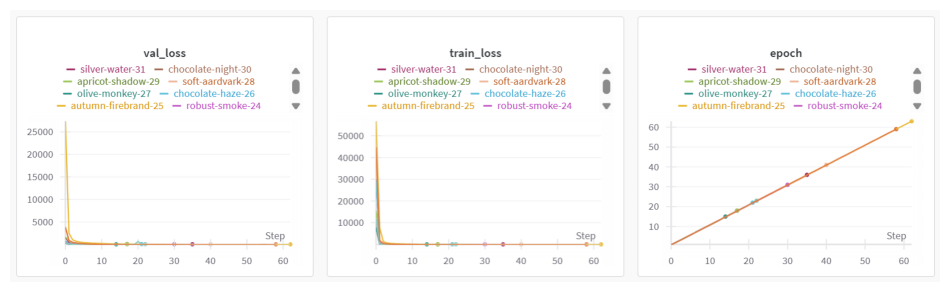

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "S1_NN_loss.png"
img = mpimg.imread(image_path)

plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

Find the best model

In [51]:
import wandb
import os

api = wandb.Api()

project_path = "yixuan228-imperial-college-london/DE_Groupwork G4"
runs = api.runs(project_path)  # Get all the runs

# save_dir = "wandb_artifacts"
# os.makedirs(save_dir, exist_ok=True)

Save all the model config

In [52]:
ls_summary, ls_config = [], []

best_run = None
best_val_loss = float('inf')

ls_config = [run.config for run in runs]
ls_summary = [run.summary._json_dict for run in runs]


Select the best model

In [53]:
best_run = None
best_loss = float("inf")  

for run in runs:
    # print(run.summary.keys())
    if "val_loss" in run.summary:  
        loss = run.summary["val_loss"]
        if loss < best_loss:  # best model with least loss
            best_loss = loss
            best_run = run

# Best model hyparparameters
if best_run:
    print("\nBest Model Found:")
    print(f"Run ID: {best_run.id}, Name: {best_run.name}, State: {best_run.state}")
    print(f"Lowest Validation Loss: {best_loss}")

    print("\nBest Model Hyperparameters (config):")
    for key, value in best_run.config.items():
        print(f"   {key}: {value}")

    print("\nBest Model Final Metrics (summary):")
    for key, value in best_run.summary.items():
        print(f"   {key}: {value}")
else:
    print("No valid runs found with 'loss' metric.")



Best Model Found:
Run ID: nbfzlfhc, Name: fearless-morning-12, State: finished
Lowest Validation Loss: 8.600484386515094

Best Model Hyperparameters (config):
   patience: 5
   max_epochs: 200
   hidden_units: 64
   hidden_layers: 2
   learning_rate: 0.001

Best Model Final Metrics (summary):
   _runtime: 19.7579481
   _step: 118
   _timestamp: 1742462047.419305
   _wandb: {'runtime': 19}
   epoch: 119
   train_loss: 8.823451982218003
   val_loss: 8.600484386515094


#### 3.1.4 Best NN Model Parameters

Using Nueral Network Models is a good way to predict the CO2 emssions based on the features given. After using W&B to grid search the hyperparameters grid, the best model is chosen based on the metric of validation loss.

The best model parameters are listed below:

**Hyperparameter**:\
    patience: 5\
    max_epochs: 200\
    hidden_units: 64\
    hidden_layers: 2\
    learning_rate: 0.001

**Running Performance:**\
    epoch: 119\
    Training loss: 8.823451982218003\
    Validation loss: 8.600484386515094




#### 3.1.5 K-fold on Best NN Model 

Initialize NN model configuration, set hyperparameter grid.

In [54]:
# Hyperparameter grid
hidden_size = 64    # Numbers of neurons in each hidden layer
num_layer = 2       # Numbers of hidden layers
learning_rate = 0.001     # Learning rates

num_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
batch_size = 64
patience = 5      # Early stopping patience

input_size =  X_train_processed.shape[1]   # Input size 
output_size = 1             # Output size

Output k-fold validation results

In [55]:
from torch.utils.data import Subset
from torch import optim

# Save MSE and True/Predict Values---------------------------
nn_k_fold_mse = []
nn_k_fold_R2 = []
nn_k_fold_mae = []
nn_k_fold_mape = []   

# Train and Evaluate the model----------------------------
print(f'Best Neural Network Model:\n')
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train_df)):

    # get the training and validation data
    train_subset  = Subset(train_dataset, train_index)
    val_subset = Subset(train_dataset, val_index)

    # Data loader
    train_loader = DataLoader(dataset=train_subset , batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

    # Initialize and train the model
    nn_model = MultiLayerPerceptron(input_size, hidden_size, num_layer, output_size).to(device)

    criterion = nn.MSELoss()  # MSE as loss function
    optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)  # Adam as optimizer

    for epoch in range(num_epochs):
        nn_model.train()
        total_loss = 0
        i = 0

        for X_batch, y_batch in train_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # if (epoch+1) % 10 == 0:
        #     print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # Validate the model
    nn_model.eval()

    y_true_fold = []
    y_pred_fold = []

    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

            # y_true_fold.append(y_batch.cpu.numpy())     
            # y_pred_fold.append(y_pred.cpu.numpy())      

            y_true_fold.append(y_batch.cpu().detach().numpy())  # true value
            y_pred_fold.append(y_pred.cpu().detach().numpy())   # predicted value

    y_true_fold = np.concatenate(y_true_fold, axis=0).flatten()
    y_pred_fold = np.concatenate(y_pred_fold, axis=0).flatten()

    mse = mean_squared_error(y_true_fold, y_pred_fold)
    r2 = r2_score(y_true_fold, y_pred_fold)
    mae = mean_absolute_error(y_true_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_true_fold, y_pred_fold)

    nn_k_fold_mse.append(mse)
    nn_k_fold_R2.append(r2)
    nn_k_fold_mae.append(mae)
    nn_k_fold_mape.append(mape)
    
    print(f"Fold {fold+1} Validation Dataset MSE: {mse:.4f}")

print(f"\nK-Fold Average MSE: {np.mean(nn_k_fold_mse):.4f}")
print(f"\n--------Finished training and validating the model!--------")


Best Neural Network Model:

Fold 1 Validation Dataset MSE: 5.8574
Fold 2 Validation Dataset MSE: 6.7286
Fold 3 Validation Dataset MSE: 9.0064
Fold 4 Validation Dataset MSE: 7.8659
Fold 5 Validation Dataset MSE: 8.1476
Fold 6 Validation Dataset MSE: 7.5024
Fold 7 Validation Dataset MSE: 7.7546
Fold 8 Validation Dataset MSE: 10.0243
Fold 9 Validation Dataset MSE: 6.0782
Fold 10 Validation Dataset MSE: 18.0112
Fold 11 Validation Dataset MSE: 11.5061
Fold 12 Validation Dataset MSE: 6.1962
Fold 13 Validation Dataset MSE: 7.1398
Fold 14 Validation Dataset MSE: 7.7552
Fold 15 Validation Dataset MSE: 7.7319
Fold 16 Validation Dataset MSE: 5.5992
Fold 17 Validation Dataset MSE: 7.4864
Fold 18 Validation Dataset MSE: 6.8686
Fold 19 Validation Dataset MSE: 7.7640
Fold 20 Validation Dataset MSE: 7.0892

K-Fold Average MSE: 8.1057

--------Finished training and validating the model!--------


Neural Network Model:
    Test Dataset MSE: 8.3357
    Test Dataset R2: 0.9976
    Test Dataset MAE: 2.2142
    Test Dataset MAPE: 0.0089


Text(0.5, 1.0, 'Neural Network Model: Observed vs Predicted values')

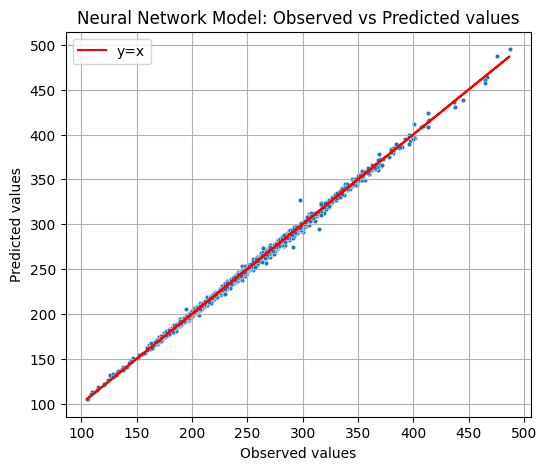

In [56]:
# Test the model on the test dataset------------------------   
# Using MSE as the evaluation metrics: Mean Squared Error, R2, MAE, MAPE
nn_model.eval()

# Get the prediction and true values
nn_test_true = []
nn_test_pred = []

val_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_Loader:

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = nn_model(X_batch)
        loss = criterion(y_pred, y_batch)
        val_loss += loss.item()

        nn_test_true.append(y_batch.cpu().detach().numpy())     # true value
        nn_test_pred.append(y_pred.cpu().detach().numpy())      # predicted value

# concatenate the true and predicted values
nn_test_true = np.concatenate(nn_test_true, axis=0).flatten()
nn_test_pred = np.concatenate(nn_test_pred, axis=0).flatten()

nn_test_r2 = r2_score(nn_test_pred, nn_test_true)
nn_test_mse = mean_squared_error(nn_test_pred, nn_test_true)
nn_test_mae = mean_absolute_error(nn_test_pred, nn_test_true)
nn_test_mape = mean_absolute_percentage_error(nn_test_pred, nn_test_true)

# Output
print(f'Neural Network Model:')
print(f"    Test Dataset MSE: {nn_test_mse:.4f}")
print(f"    Test Dataset R2: {nn_test_r2:.4f}")
print(f"    Test Dataset MAE: {nn_test_mae:.4f}")
print(f"    Test Dataset MAPE: {nn_test_mape:.4f}")

# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(nn_test_true, nn_test_pred, ax)
plt.title('Neural Network Model: Observed vs Predicted values')

In [57]:
print(f"Test Dataset MSE: {nn_test_mse:.4f}")
print(f"Validation Dataset MSE: {np.mean(nn_k_fold_mse):.4f}")

Test Dataset MSE: 8.3357
Validation Dataset MSE: 8.1057


### 3.1.6 Save the NN Model Performance

Output of Best NN Model

- Output will include two types of data: Validation values, and Test Values, and combine those into one dataframe.

- Validation RSE:  1 x 20    Test RSE: 1 x 1

- Validation R2:   1 x 20    Test R2:  1 x 1

- Validation MAE:  1 x 20    Test MAE:  1 x 1

- Validation MAPE: 1 x 20    Test MAPE:  1 x 1

- So the output dataframe should include:

    - **4 rows**: RSE, R2, MAE and MAPE 
    
    - **21 cols**:  first 20 as validation metrics, with the last one being test metric

In [58]:
# Save the output of Best NN Model 
nn_metrics = pd.DataFrame([nn_k_fold_mse, nn_k_fold_R2, nn_k_fold_mae, nn_k_fold_mape])

# Add Test results
nn_metrics["Test_results"] = [nn_test_mse, nn_test_r2, nn_test_mae, nn_test_mape]


In [59]:
nn_metrics.columns = [f"fold_{i+1}" for i in range(20)] + ["Test"]
nn_metrics.index = ['MSE', 'R2', 'MAE', 'MAPE']


In [60]:
nn_metrics

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,...,fold_12,fold_13,fold_14,fold_15,fold_16,fold_17,fold_18,fold_19,fold_20,Test
MSE,5.857437,6.728559,9.006442,7.865871,8.147576,7.502366,7.754570,10.024302,6.078247,18.011175,...,6.196240,7.139805,7.755204,7.731935,5.599160,7.486383,6.868587,7.763961,7.089190,8.335684
R2,0.998230,0.998216,0.997778,0.997771,0.997430,0.997941,0.997778,0.996678,0.998234,0.994896,...,0.998213,0.997801,0.997169,0.997733,0.998348,0.997714,0.998017,0.997434,0.998030,0.997572
MAE,1.931306,1.980967,2.300202,2.120462,2.210552,2.142294,2.038177,2.355817,1.874738,2.161819,...,1.955013,2.031846,2.233384,2.176812,1.902452,2.132320,2.140041,2.034079,2.135943,2.214224
MAPE,0.008010,0.007858,0.008902,0.008478,0.008880,0.008750,0.008438,0.009592,0.007786,0.009594,...,0.007862,0.008277,0.009020,0.008711,0.007797,0.008616,0.008508,0.008250,0.008434,0.008907


In [61]:
nn_test_pred

array([360.49088, 292.63724, 381.6401 , ..., 344.32492, 192.3342 ,
       177.06665], dtype=float32)

In [63]:
nn_metrics.to_csv("Best_NN_Model_performance.csv", index=True)